## Download Data

In [ ]:
!wget http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz

--2021-04-04 10:51:15--  http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Amazon_Instant_Video_5.json.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9517526 (9.1M) [application/x-gzip]
Saving to: ‘reviews_Amazon_Instant_Video_5.json.gz’

reviews_Amazon_Inst 100%[===================>]   9.08M  1.75MB/s    in 5.2s    

2021-04-04 10:51:21 (1.75 MB/s) - ‘reviews_Amazon_Instant_Video_5.json.gz’ saved [9517526/9517526]



## Importing required libraries

In [ ]:
import re
import os
import json
import gzip
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

from gensim.models import Word2Vec
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB , BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,plot_confusion_matrix

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

#!pip install ipython-autotime
#%load_ext autotime

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

## Loading Data

In [ ]:
# load data
data = []
with gzip.open('reviews_Amazon_Instant_Video_5.json.gz') as file:
    for line in file:
        data.append(json.loads(line.strip()))

# convert list into pandas dataframe
df = pd.DataFrame.from_dict(data)

print('Total number of reviews are: ',len(data))

# Viewing first 5 reviews
df.head(5)

Total number of reviews are:  37126


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,2.0,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,5.0,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,1.0,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,4.0,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",5.0,Robson green and great writing,1234310400,"02 11, 2009"


**Attribute Information:**

1. reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

2. asin - ID of the product, e.g. 0000013714

3. reviewerName - name of the reviewer

4. helpful - helpful votes of the review

5. reviewText - text of the review

6. overall - rating of the product

7. summary - summary of the review

8. unixReviewTime - time of the review (unix time)

9. reviewTime - time of the review (raw)


In [ ]:
df.columns #verifying for columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

## Modifying the overall to our requirements

In [ ]:
def modify_overall(overall):
  ''' 
  Function to modify overall:
    overall greater than 3 is changed to 1(positive sentiment) 
    overall less than or equal to 3 is changed to 0(negative sentiment)
  Input: overall
  Output: Modified overall
  '''
  if overall <= 3:
      return 0
  return 1

In [ ]:
actualScore = df['overall']
new_score = actualScore.map(modify_overall) 
df['overall'] = new_score
print("Number of data points in our data", df.shape)
df.head()

Number of data points in our data (37126, 9)


,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A11N155CW1UV02,B000H00VBQ,AdrianaM,"[0, 0]",I had big expectations because I love English ...,0,A little bit boring for me,1399075200,"05 3, 2014"
1,A3BC8O2KCL29V2,B000H00VBQ,Carol T,"[0, 0]",I highly recommend this series. It is a must f...,1,Excellent Grown Up TV,1346630400,"09 3, 2012"
2,A60D5HQFOTSOM,B000H00VBQ,"Daniel Cooper ""dancoopermedia""","[0, 1]",This one is a real snoozer. Don't believe anyt...,0,Way too boring for me,1381881600,"10 16, 2013"
3,A1RJPIGRSNX4PW,B000H00VBQ,"J. Kaplan ""JJ""","[0, 0]",Mysteries are interesting. The tension betwee...,1,Robson Green is mesmerizing,1383091200,"10 30, 2013"
4,A16XRPF40679KG,B000H00VBQ,Michael Dobey,"[1, 1]","This show always is excellent, as far as briti...",1,Robson green and great writing,1234310400,"02 11, 2009"


## Cleaning Data

In [ ]:
''' Remove the duplicates which have same reviewerID, asin, unixReviewTime, and reviewText '''
new = df.drop_duplicates(subset={"reviewerID","asin","unixReviewTime","reviewText"}, keep='first', inplace=False)
new.shape

(37126, 9)

In [ ]:

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ma'])

## Required functions

In [ ]:
def decontracted(phrase):
    ''' 
      Function used to decontact the words in the phrase
      Input: phrase
      Output: decontracted phrase
    '''
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
def pipeline(review): 
  '''
     Input: list of review
     Output: processed reviews 
  '''
  processed_reviews = []
  for sentence in tqdm(review):
    sentence = sentence.lower() #converting all letters in the sentence to lowercase
    sentence = decontracted(sentence) #decontact the sentence in the review
    sentence = re.sub('[^A-Za-z]+', ' ', sentence) #retaining only alphabets in the sentence 

    #Word tokenization
    word_tokens = word_tokenize(sentence) 

    #Stop word removal
    filtered_sentence = [w for w in word_tokens if  w not in stopwords]
    
    #Lemmatization
    wnl = WordNetLemmatizer()
    filtered_sentence = [wnl.lemmatize(w) for w in filtered_sentence ]

    final = ' '.join(filtered_sentence)
    processed_reviews.append(final)
  return processed_reviews


## Creating required variables

In [ ]:
reviews = df['reviewText'].values
score = df['overall'].values

In [ ]:
#filtering review
reviews = pipeline(reviews)

100%|██████████| 37126/37126 [00:27<00:00, 1353.78it/s]


In [ ]:
reviews_train , reviews_test , score_train, score_test = train_test_split(reviews, score,test_size=0.2)

In [ ]:
print(len(reviews_test),len(reviews_train),len(score_test),len(score_train))

7426 29700 7426 29700


# 1. Use the following vector space models
a. CountVectorizer

b. TF-IDF

c. Any external vectorizer (cite the original paper)

## CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer() 

#transformed train reviews
count_vect_train = count_vect.fit_transform(reviews_train)

#transformed test reviews
count_vect_test =  count_vect.transform(reviews_test)

print('count_vect_train size : ',count_vect_train.shape)
print('count_vect_test size : ',count_vect_test.shape)



count_vect_train size :  (29700, 43196)
count_vect_test size :  (7426, 43196)


## TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)

#transformed train reviews
tf_idf_vect_test = tf_idf_vect.fit_transform(reviews_train)

#transformed test reviews
tf_idf_vect_test =  tf_idf_vect.transform(reviews_test)

print('tf_idf_vect_train size : ',tf_idf_vect_test.shape)
print('tf_idf_vect_test size : ',tf_idf_vect_test.shape)


tf_idf_vect_train size :  (7426, 20846)
tf_idf_vect_test size :  (7426, 20846)


In [ ]:
from joblib import dump, load
dump(tf_idf_vect, 'tfidfmodel.joblib') 

['tfidfmodel.joblib']

 ## Hashing Vectorizer

In [ ]:
from sklearn.feature_extraction.text import HashingVectorizer


In [ ]:
hash_vect = HashingVectorizer(binary = True, alternate_sign=False  , n_features=50)

#transformed train reviews
hash_vect_train = hash_vect.fit_transform(reviews_train)

#transformed test reviews
hash_vect_test =  hash_vect.transform(reviews_test)

print('hash_vect_vect_train size : ',hash_vect_train.shape)
print('hash_vect_test size : ',hash_vect_test.shape)



hash_vect_vect_train size :  (29700, 50)
hash_vect_test size :  (7426, 50)


#2. Do sentiment analysis using all (a,b,c) using classical ML techniques
a. Naive Bayes Model

b. Decision Tree

c. Logistic Regression

#3. Report metrics [accuracy, f1 score, confusion matrix] for all the combinations in (1 and 2)




## a. Naive Bayes Model

### CountVectorizer

In [ ]:
#training  the model

NB_count_vect = MultinomialNB()

NB_count_vect = NB_count_vect.fit(count_vect_train,score_train)
print(NB_count_vect)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [ ]:
#Prediction
NB_count_vect_predict=NB_count_vect.predict(count_vect_test)

#### Metrics

In [ ]:
# Accuracy

NB_count_vect_acc = accuracy_score(score_test,NB_count_vect_predict)
print("Accuracy Using Multinomial Naive Bayes and Count Vectorizer :",round(NB_count_vect_acc*100,2),'%')

Accuracy Using Multinomial Naive Bayes and Count Vectorizer : 84.96 %


In [ ]:
#F1 Score
NB_count_vect_f1_score = f1_score(score_test,NB_count_vect_predict)
print("F1 Score Using Multinomial Naive Bayes classifier and Count Vectorizer :",round(NB_count_vect_f1_score,2))

F1 Score Using Multinomial Naive Bayes classifier and Count Vectorizer : 0.91


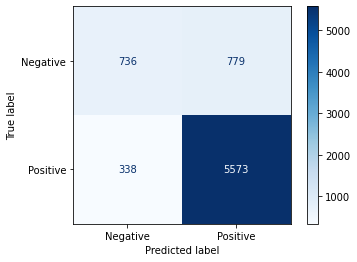

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(NB_count_vect, count_vect_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

### TF-IDF

In [ ]:
#training  the model

NB_tf_idf_vect = MultinomialNB()

NB_tf_idf_vect = NB_tf_idf_vect.fit(tf_idf_vect_train,score_train)
print(NB_tf_idf_vect)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)


In [ ]:
#Prediction
NB_tf_idf_vect_predict=NB_tf_idf_vect.predict(tf_idf_vect_test)

#### Metrics

In [ ]:
# Accuracy

NB_tf_idf_vect_acc = accuracy_score(score_test,NB_tf_idf_vect_predict)
print("Accuracy Using Multinomial Naive Bayes and TF-IDF Vect :",round(NB_tf_idf_vect_acc*100,2),'%')

Accuracy Using Multinomial Naive Bayes and TF-IDF Vect : 84.23 %


In [ ]:
#F1 Score
NB_tf_idf_vect_f1_score = f1_score(score_test,NB_tf_idf_vect_predict)
print("F1 Score Using Multinomial Naive Bayes classifier and TF-IDF Vect :",round(NB_tf_idf_vect_f1_score,2))

F1 Score Using Multinomial Naive Bayes classifier and TF-IDF Vect : 0.91


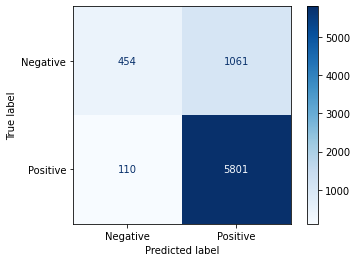

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(NB_tf_idf_vect, tf_idf_vect_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

### Hashing Vectorizer

In [ ]:
#training  the model
NB_hash_vect = BernoulliNB()

NB_hash_vect = NB_hash_vect.fit(hash_vect_train,score_train)
print(NB_hash_vect)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)


In [ ]:
#Prediction
NB_hash_vect_predict=NB_hash_vect.predict(hash_vect_test)

#### Metrics

In [ ]:
# Accuracy

NB_hash_vect_acc = accuracy_score(score_test,NB_hash_vect_predict)
print("Accuracy Using Multinomial Naive Bayes with hash vect :",round(NB_hash_vect_acc*100,2),'%')

Accuracy Using Multinomial Naive Bayes with hash vect : 68.72 %


In [ ]:
#F1 Score
NB_hash_vect_f1_score = f1_score(score_test,NB_hash_vect_predict)
print("F1 Score Using Multinomial Naive Bayes classifier with hash vect :",round(NB_hash_vect_f1_score,2))

F1 Score Using Multinomial Naive Bayes classifier with hash vect : 0.79


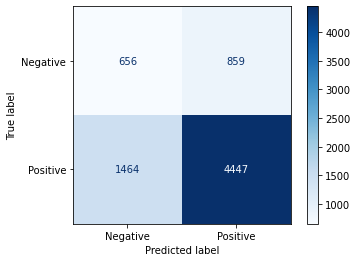

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(NB_hash_vect, hash_vect_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

## b. Decision Tree

### CountVectorizer

In [ ]:
#training  the model

Dtree_count_vect = DecisionTreeClassifier(random_state=0)

Dtree_count_vect = Dtree_count_vect.fit(count_vect_train,score_train)
print(Dtree_count_vect)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


In [ ]:
#Prediction
Dtree_count_vect_predict=Dtree_count_vect.predict(count_vect_test)

#### Metrics

In [ ]:
# Accuracy

Dtree_count_vect_acc = accuracy_score(score_test,Dtree_count_vect_predict)
print("Accuracy Using Decision Tree Classifier and Count Vectorizer :",round(Dtree_count_vect_acc*100,2),'%')

Accuracy Using Decision Tree Classifier and Count Vectorizer : 77.65 %


In [ ]:
#F1 Score
Dtree_count_vect_f1_score = f1_score(score_test,Dtree_count_vect_predict)
print("F1 Score Using Decision Tree classifier and Count Vectorizer :",round(Dtree_count_vect_f1_score,2))

F1 Score Using Decision Tree classifier and Count Vectorizer : 0.86


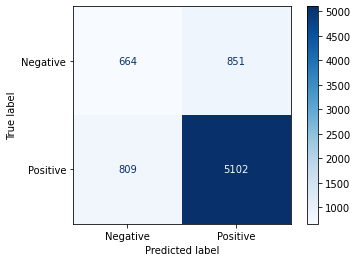

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(Dtree_count_vect, count_vect_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

### TF-IDF

In [ ]:
#training  the model

Dtree_tf_idf_vect = DecisionTreeClassifier(random_state=0)

Dtree_tf_idf_vect = Dtree_tf_idf_vect.fit(tf_idf_vect_train,score_train)
print(Dtree_tf_idf_vect)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


In [ ]:
#Prediction
Dtree_tf_idf_vect_predict=Dtree_tf_idf_vect.predict(tf_idf_vect_test)

#### Metrics

In [ ]:
# Accuracy

Dtree_tf_idf_vect_acc = accuracy_score(score_test,Dtree_tf_idf_vect_predict)
print("Accuracy Using Decision Tree Classifier and TF-IDF Vector :",round(Dtree_tf_idf_vect_acc*100,2),'%')

Accuracy Using Decision Tree Classifier and TF-IDF Vector : 76.88 %


In [ ]:
#F1 Score
Dtree_tf_idf_vect_f1_score = f1_score(score_test,Dtree_tf_idf_vect_predict)
print("F1 Score Using Decision Tree classifier and TF-IDF :",round(Dtree_tf_idf_vect_f1_score,2))

F1 Score Using Decision Tree classifier and TF-IDF : 0.85


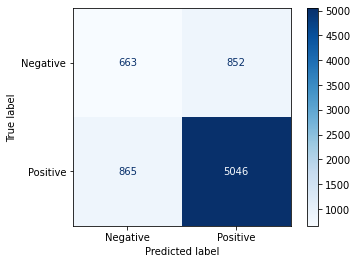

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(Dtree_tf_idf_vect, tf_idf_vect_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

### Hashing Vectorizer

In [ ]:
#training  the model

Dtree_hash_vect = DecisionTreeClassifier(random_state=0)

Dtree_hash_vect = Dtree_hash_vect.fit(hash_vect_train,score_train)
print(Dtree_hash_vect)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')


In [ ]:
#Prediction
Dtree_hash_vect_predict=Dtree_hash_vect.predict(hash_vect_test)

#### Metrics

In [ ]:
# Accuracy

Dtree_hash_vect_acc = accuracy_score(score_test,Dtree_hash_vect_predict)
print("Accuracy Using Decision Tree with hash vect :",round(Dtree_hash_vect_acc*100,2),'%')

Accuracy Using Decision Tree with hash vect : 69.77 %


In [ ]:
#F1 Score
Dtree_hash_vect_f1_score = f1_score(score_test,Dtree_hash_vect_predict)
print("F1 Score Decision Tree classifier with hash vect :",round(Dtree_hash_vect_f1_score,2))

F1 Score Decision Tree classifier with hash vect : 0.81


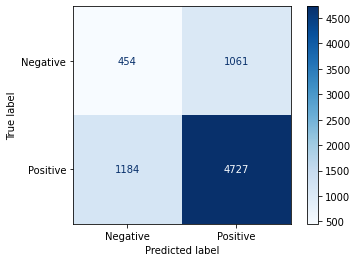

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(Dtree_hash_vect, hash_vect_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

## c. Logistic Regression

### CountVectorizer

In [ ]:
#training  the model

lr_count_vect = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

lr_count_vect = lr_count_vect.fit(count_vect_train,score_train)
print(lr_count_vect)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
#Prediction
lr_count_vect_predict=lr_count_vect.predict(count_vect_test)

#### Metrics

In [ ]:
# Accuracy

lr_count_vect_acc = accuracy_score(score_test,lr_count_vect_predict)
print("Accuracy Using Linear Regression and Count Vectorizer :",round(lr_count_vect_acc*100,2),'%')

Accuracy Using Linear Regression and Count Vectorizer : 86.14 %


In [ ]:
#F1 Score
lr_count_vect_f1_score = f1_score(score_test,lr_count_vect_predict)
print("F1 Score Using Linear Regression and Count Vectorizer :",round(lr_count_vect_f1_score,2))

F1 Score Using Linear Regression and Count Vectorizer : 0.91


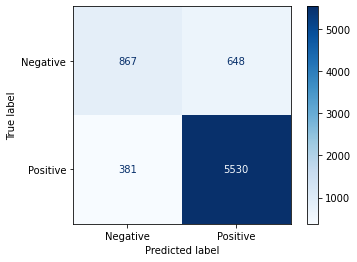

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(lr_count_vect, count_vect_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

### TF-IDF

In [ ]:
#training  the model

lr_tf_idf_vect = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

lr_tf_idf_vect.fit(tf_idf_vect_train,score_train)
print(lr_tf_idf_vect)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
from joblib import dump, load
dump(lr_tf_idf_vect, 'lrmodel.joblib') 

['lrmodel.joblib']

In [ ]:
#Prediction
lr_tf_idf_vect_predict=lr_tf_idf_vect.predict(tf_idf_vect_test)

#### Metrics

In [ ]:
# Accuracy

lr_tf_idf_vect_acc = accuracy_score(score_test,lr_tf_idf_vect_predict)
print("Accuracy Using Linear Regression and TF-IDF Vector :",round(lr_tf_idf_vect_acc*100,2),'%')

Accuracy Using Linear Regression and TF-IDF Vector : 87.33 %


In [ ]:
#F1 Score
lr_tf_idf_vect_f1_score = f1_score(score_test,lr_tf_idf_vect_predict)
print("F1 Score Using Linear Regression and TF-IDF Vector :",round(lr_tf_idf_vect_f1_score,2))

F1 Score Using Linear Regression and TF-IDF Vector : 0.92


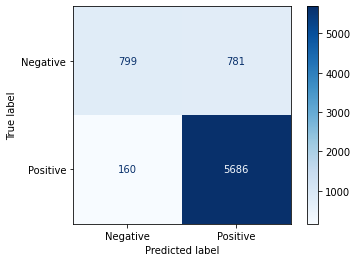

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(lr_tf_idf_vect, tf_idf_vect_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()

### Hashing Vectorizer

In [ ]:
#training  the model

lr_hash_vect = LogisticRegression(penalty='l2',max_iter=500,C=1,random_state=42)

lr_hash_vect = lr_hash_vect.fit(hash_vect_train,score_train)
print(lr_hash_vect)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [ ]:
#Prediction
lr_hash_vect_predict=lr_hash_vect.predict(hash_vect_test)

#### Metrics

In [ ]:
# Accuracy

lr_hash_vect_acc = accuracy_score(score_test,lr_hash_vect_predict)
print("Accuracy Using Linear Regression with hash vect :",round(lr_hash_vect_acc*100,2),'%')

Accuracy Using Linear Regression with hash vect : 79.83 %


In [ ]:
#F1 Score
lr_hash_vect_f1_score = f1_score(score_test,lr_hash_vect_predict)
print("F1 Score Using Linear Regression classifier with hash vect :",round(lr_hash_vect_f1_score,2))

F1 Score Using Linear Regression classifier with hash vect : 0.89


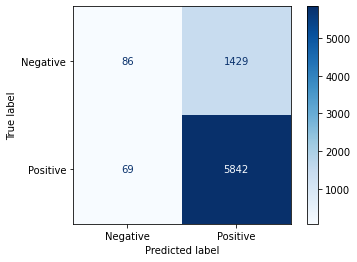

In [ ]:
#Confusion Matrix
class_names = ['Negative','Positive']
plot_confusion_matrix(lr_hash_vect, hash_vect_test, score_test,display_labels=class_names,cmap=plt.cm.Blues,values_format = '.0f')
plt.show()